# Kalman Filter Exercise
This is the supplementary Python code for the Exercise 6.4 in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press". <br>
The exercise consists in completing the function `kf_predict_update` which has the signature:

```python

def update_method(x, cov, obs): 
    """ Update the state belief based on prior belief and new observation
    """
    # Do something
    return updated_x, updated_cov

```

## Standard imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg

np.random.seed(31415926)

## Utility functions

In [2]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + linalg.cholesky(C, lower=True) @ sample

In [3]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [4]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [5]:
def plot_results(filtered_states, true_states, observations, title, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0].plot(filtered_states[:, 0], label="Estimated signal", color="b")
    axes[0].plot(true_states[:, 0], label="True signal", linestyle='--', color="r")
    axes[0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1].plot(filtered_states[:, 1], label="Estimated derivative", color="b")
    axes[1].plot(true_states[:, 1], label="True derivative", linestyle='--', color="r")
    
    error = rmse(filtered_states, true_states)
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - filtered_covariances[:, 0, 0],
                             filtered_states[:, 0] + filtered_covariances[:, 0, 0],
                             alpha=0.33, 
                             color="b")
        axes[1].fill_between(np.arange(T), 
                             filtered_states[:, 1] - filtered_covariances[:, 1, 1],
                             filtered_states[:, 1] + filtered_covariances[:, 1, 1],
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE: {error:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE = {error:.3f}")


## Get data

We generate $T=100$ observations according to the following model: 
\begin{equation}
    x_t = A x_{t-1} + \mathcal{N}(0, Q), \quad y_t = \left(\begin{matrix}1 & 0\end{matrix}\right) x_t + \mathcal{N}(0, r), \quad x_0 = \left(\begin{matrix}0 & 0.1\end{matrix}\right)^T
\end{equation}

where we have $A = \left(\begin{matrix} \cos(\omega) & \frac{\sin(\omega)}{\omega} \\ -\omega \sin(\omega) & \cos(\omega)\end{matrix}\right), \quad 
Q = \frac 1 2 q \left(\begin{matrix}
                \frac{\omega - \cos(\omega) \sin(\omega)}{\omega^3} &
                \frac{\sin(\omega) ^2 }{\omega^2}   
            \\
                \frac{\sin(\omega) ^2 }{\omega^2}  &
                \frac{\omega + \cos(\omega) \sin(\omega)}{\omega} 
        \end{matrix}\right)$


For the remainder of the notebook, we will take: 
- $\omega = 0.5$
- $q = 0.01$
- $r = 0.1$

In [6]:
w = 0.5
q = 0.01
r = 0.1

T = 100
x_0 = np.array([0, 0.1])

In [7]:
def get_data(w, q, r, x_0, T):
    """ Generates data according to the state space model above
    Example:
    >>> observations, true_states, _, _, _ = get_data(0.25, 0.01, 0.1, np.array([0, 0.1]), 50)
    >>> observations.shape[0] == true_states.shape[0] == 50
    True
    """
    Q = 0.5 * q * np.array([[(w - np.cos(w) * np.sin(w)) / w ** 3, np.sin(w) ** 2 / w ** 2],
                            [np.sin(w) ** 2 / w ** 2, (w + np.cos(w) * np.sin(w)) / w]])
    
    A = np.array([[np.cos(w), np.sin(w) / w], 
                  [-w * np.sin(w), np.cos(w)]])
    
    C = np.array([1, 0])
    
    observations = np.empty(T)
    true_states = np.empty((T, 2))
    
    x = x_0[:]
    true_states[0] = x
    
    for i in range(T):
        observations[i] = C.dot(x) + np.sqrt(r) * np.random.randn()
        x = mv_normal(np.matmul(A, x), Q)
        if i == T-1:
            break
        true_states[i+1, :] = x
        
    return observations, true_states, Q, A, C


In [8]:
observations, true_states, Q, A, C = get_data(w, q, r, x_0, T)

In [9]:
def plot_state(observations, true_states, T):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(true_states[:, 0], linestyle='--', label="True Signal")
    ax.scatter(np.arange(T), observations, marker='o', label="Measurements")
    ax.set_xlabel("Time step")
    ax.legend(loc="upper left")
    fig.suptitle("Simulated data")

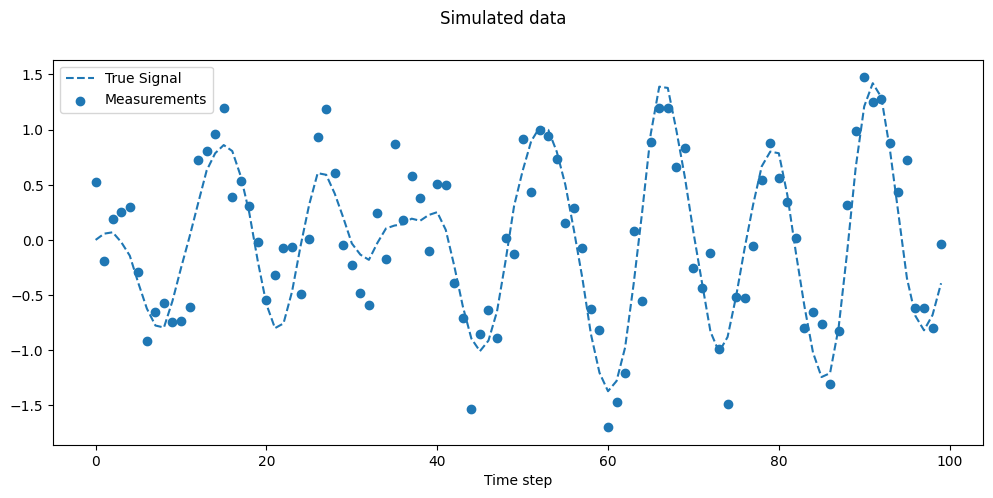

In [10]:
plot_state(observations, true_states, T)

## Initial Guess

We will now consider that our initial guess for the first state is given by $x_0 \sim \mathcal{N}\left(\left(\begin{matrix}0 \\ 1\end{matrix}\right), I_2\right)$

In [11]:
initial_state = np.array([0, 1])
initial_covariance = np.eye(2)

## Baseline solution

We provide a baseline solution where the first component of the state will be given directly by the observation while the second component will be given by the difference between the first component now and at the previous state:

\begin{equation} x^0_t = y_t, \quad x^1_t = x^0_t - x^0_{t-1}\end{equation}

In [12]:
def baseline_update_method(x, cov, obs):
    """ A baseline method that registers the measurement as the first component of the state, 
    and the time difference as the second component: this is a rough approximation of the time derivative.
    It does not change the covariance
    Example:
    >>> x = np.array([0.15, 0.])
    >>> cov = np.eye(2)
    >>> obs = 0.2
    >>> new_x, new_cov = baseline_update_method(x, cov, obs)
    >>> np.allclose(new_x, [0.2, 0.05])
    True
    """
    return np.array([obs, obs - x[0]]), cov

In [13]:
baseline_states, _ = filter_routine(initial_state, initial_covariance, baseline_update_method, observations)

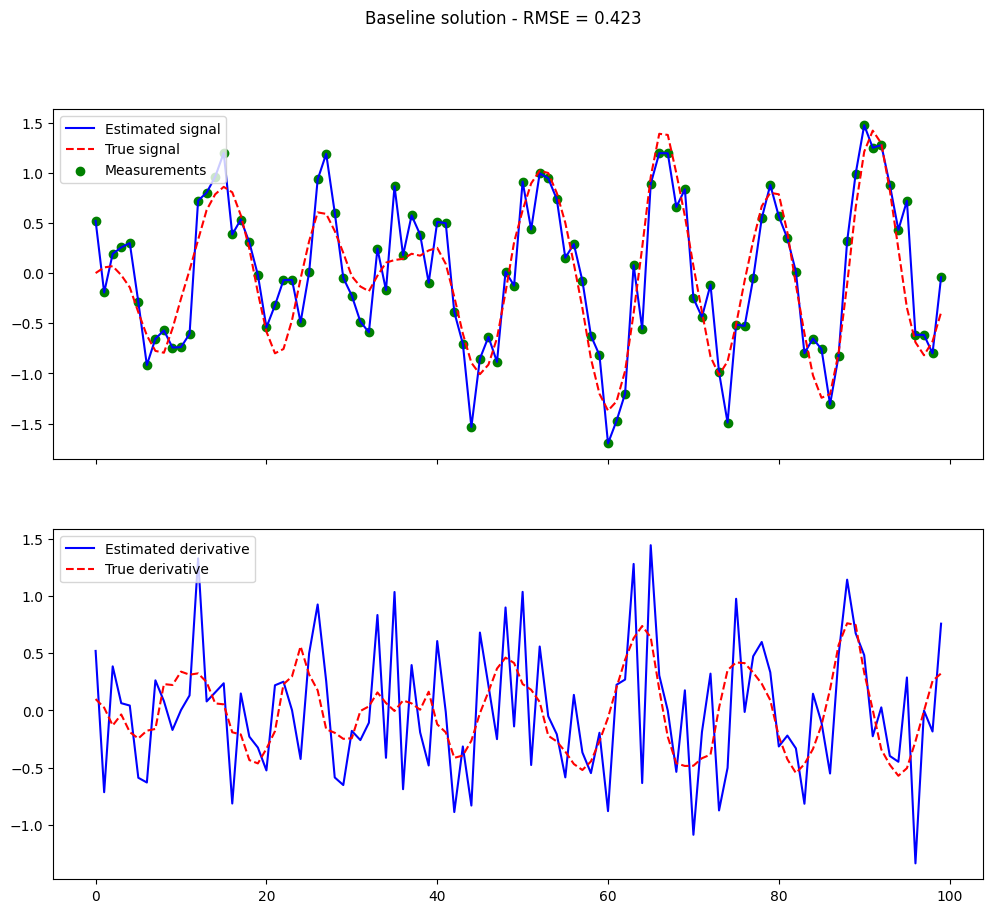

In [14]:
plot_results(baseline_states, true_states, observations, "Baseline solution", None)

## Kalman Filter

In [15]:
def kf_predict_update(x, cov, obs):
    """ Implements the kalman equations as given in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press", Ch. 6.3
    Uses the global variables A, Q, C, r
    """
    # You should replace the below equations
    new_x = x
    new_cov = cov
    return new_x, new_cov

In [16]:
kalman_states, kalman_covariances = filter_routine(initial_state, initial_covariance, kf_predict_update, observations)

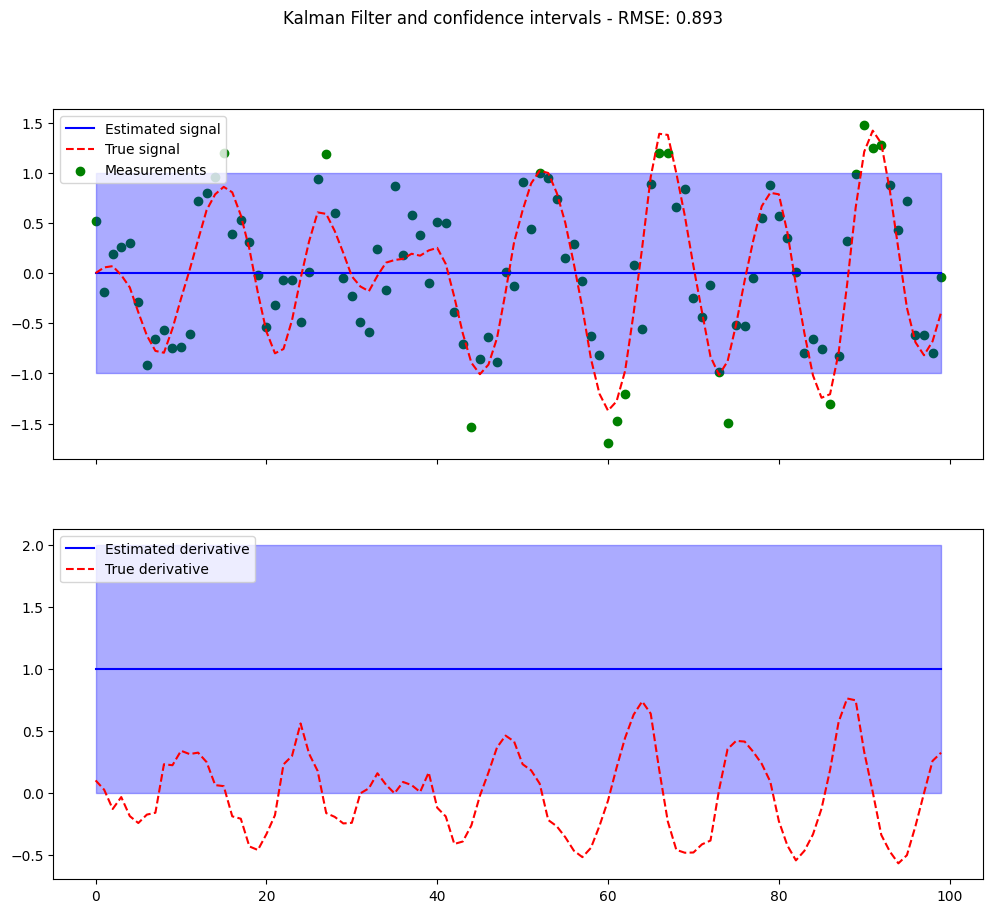

In [17]:
plot_results(kalman_states, true_states, observations, "Kalman Filter", kalman_covariances)